In [1]:
import pandas as pd
import yfinance as yf
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import gurobipy as gb

In [2]:
# function to fetch data from yahoo finance for 1 year
def FetchData(Tickers,Period="1y",Interval='1d',Start=None,End=None,Group_by='column',Column='Adj Close'):

    """
    Return the data for tickers
    Parameters:
        tickers : str, list             List of tickers to download
        period : str             Valid periods: 1d,5d,1mo,3mo,6mo,1y,2y,5y,10y,ytd,max Either Use period parameter or use start and end
        interval : str             Valid intervals: 1m,2m,5m,15m,30m,60m,90m,1h,1d,5d,1wk,1mo,3mo Intraday data cannot extend last 60 days
        start: str             Download start date string (YYYY-MM-DD) or _datetime. Default is 1900-01-01
        end: str             Download end date string (YYYY-MM-DD) or _datetime. Default is now
        group_by : str             Group by 'ticker' or 'column' (default)
    """
    StockData = yf.download(Tickers,start=Start,end=End,period=Period,interval=Interval)

    if Column!=None:
        SelectedData = StockData[Column]
    else:
        SelectedData = StockData

    return(SelectedData)



In [3]:
def Calculation(Data_Selected):
    ''' calculate the mean percent change and covariance for the stocks. Then annualized the value and return. '''
   
    Stock_pct_change = Data_Selected.pct_change()
    Mean_Change = Stock_pct_change.mean()*252
    Change_Cov = Stock_pct_change.cov()*252
    
    return(Mean_Change,Change_Cov)

In [4]:
def ComparitiveDisplay(StockData):
    # Display the growth of stocks by setting starting price to 100
    # The graph is displayed then
    ticker_list=StockData.columns
    temp_df = pd.DataFrame()
    for i in ticker_list:
        temp_df[i]=(StockData[i]/StockData[i][0])*100
    
        
    plt.figure(figsize=(20,5))
    sns.lineplot(data=temp_df)

    return()
    

In [5]:
# Selection of the Stocks for optimization
Tickers_List = ['GE','T','PG','AMZN','CL','CVS']
StockPrice = FetchData(Tickers_List)
Stock_Mean_Change, Stock_Cov_Change = Calculation(StockPrice)

[*********************100%***********************]  6 of 6 completed


()

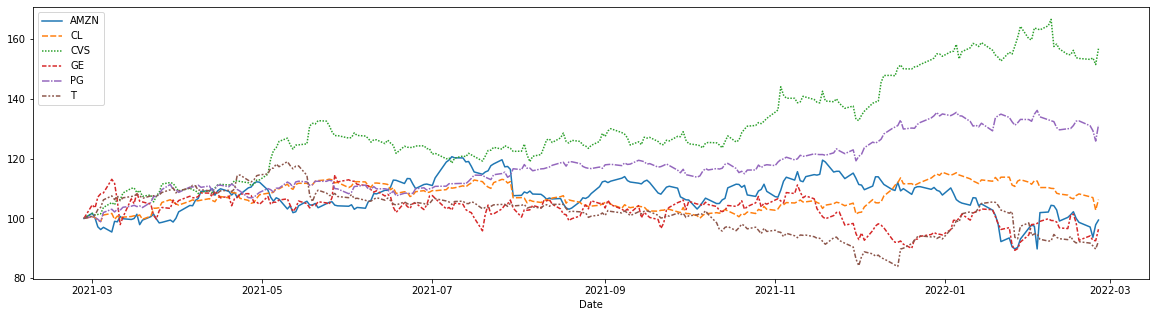

In [6]:
ComparitiveDisplay(StockPrice)

In [7]:
def Performance(weights, mean_change, change_cov):
    portfolio_return = np.dot(weights, mean_change)
    porfolio_std = np.dot(np.dot(change_cov, weights),weights)
    return(portfolio_return,porfolio_std)

In [8]:
Portfolio_Weights = np.ones(6)/6
Performance(Portfolio_Weights, Stock_Mean_Change, Stock_Cov_Change)

(0.13795581355398245, 0.01600698385056287)

In [9]:
def Efficient_Frontier_Montcarlo(Tickers,no_of_iter):
    stockdata = FetchData(Tickers)
    stock_mean_change, stock_cov_change = Calculation(stockdata)
    temp_data = pd.DataFrame(columns=['Return','Std_dev'])
    for i in range(no_of_iter):
        weights=np.random.random(6)
        portfolio_weights = weights/weights.sum()
        port_ret, port_std = Performance(portfolio_weights,stock_mean_change,stock_cov_change)
        temp1=pd.DataFrame([[port_ret,port_std]],columns=['Return','Std_dev'])
        temp_data = pd.concat([temp_data,temp1],ignore_index=True)
    plt.figure(figsize=(20,5))
    sns.scatterplot(data=temp_data,y='Return',x='Std_dev')
    return()

[*********************100%***********************]  6 of 6 completed


()

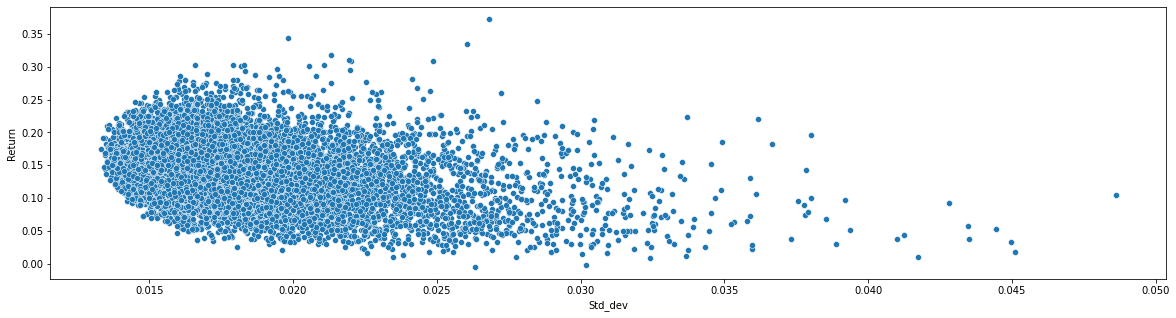

In [12]:
Efficient_Frontier_Montcarlo(Tickers_List,10000)

In [14]:
def NegSharpeRatio(Tickers,weights,RiskFreeRate):
    stockdata = FetchData(Tickers)
    stock_mean_change, stock_cov_change = Calculation(stockdata)
    port_ret, port_std = Performance(weights,stock_mean_change,stock_cov_change)

    return(-1*((port_ret-RiskFreeRate)/port_std))
    


In [21]:
NegSharpeRatio(Tickers_List, Portfolio_Weights, 0.025)

[*********************100%***********************]  6 of 6 completed


-7.056662128691449